In [1]:
%load_ext autoreload
%autoreload 2

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


In [2]:
import pandas as pd
import numpy as np

import sys
import os

import matplotlib.colors as cols
import matplotlib.pyplot as plt

from matplotlib import colormaps
from matplotlib.gridspec import GridSpec
# change the default resolution
# for better looking plots
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150

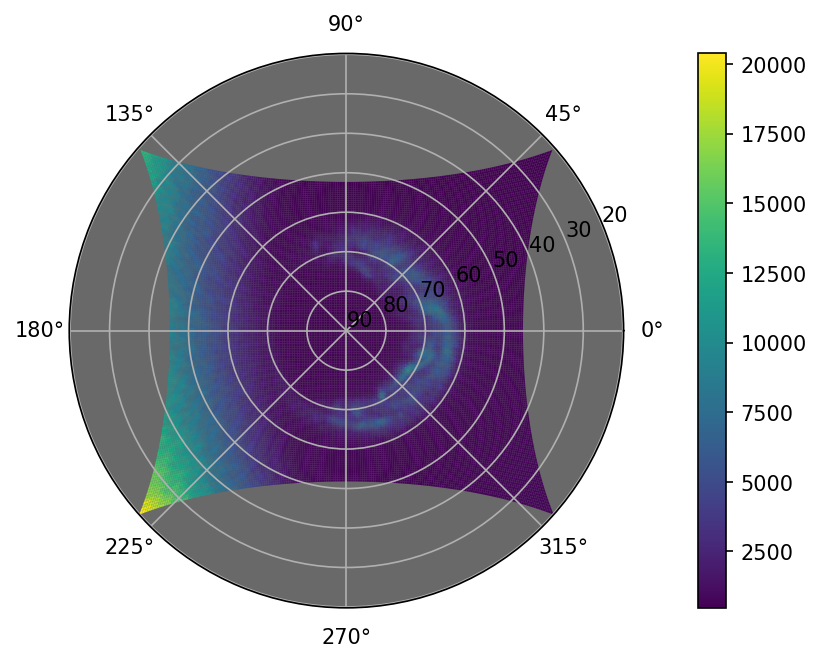

In [3]:
#add read_io module to current path ()
file_path = 'D:\\GitHub\\DataIO\\'
sys.path.append(os.path.dirname(file_path))

import data_io
import data_io.plotting as dpl

In [4]:
orb_omni = r'E:/Data/IMAGE/image_orb_omni.hdf'

orb = pd.read_hdf(orb_omni)

In [5]:
orb['z_angle'] = np.rad2deg(np.arctan2(np.sqrt(orb['X-GSM']**2+orb['Y-GSM']**2),orb['Z-GSM']))

<Axes: xlabel='DateTime'>

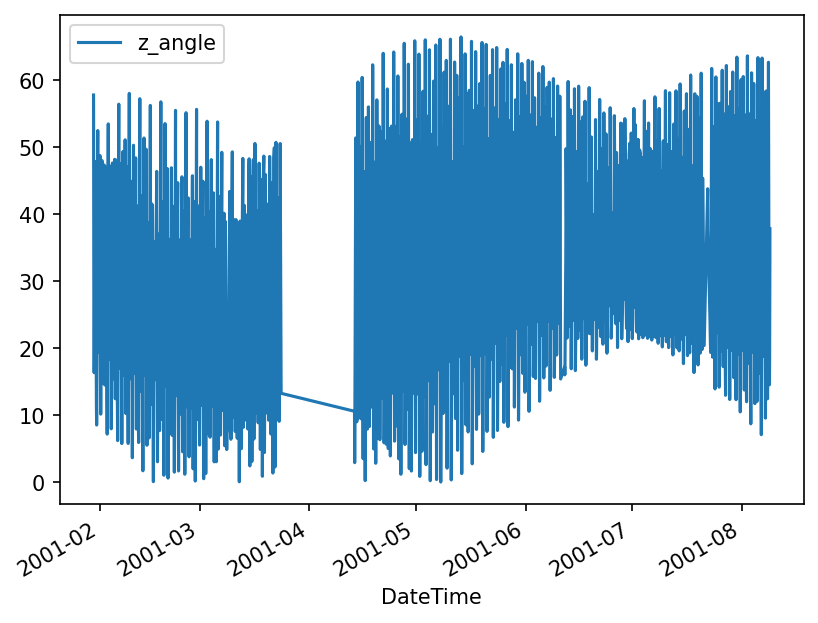

In [6]:
orb.plot(y='z_angle')

In [7]:
gd = (orb['z_angle'] < 10) & (orb['Bz_GSM'] < -4) & (orb['Bz_GSM'] > -6)

In [8]:
fn = orb.loc[gd,'filename'].to_list()

In [9]:
d = data_io.image.load_image_guvi(files=fn,local_dir='E:/Data/IMAGE/',grid=True)

(<PolarAxes: >,
 <matplotlib.colorbar.Colorbar at 0x2893b182aa0>)

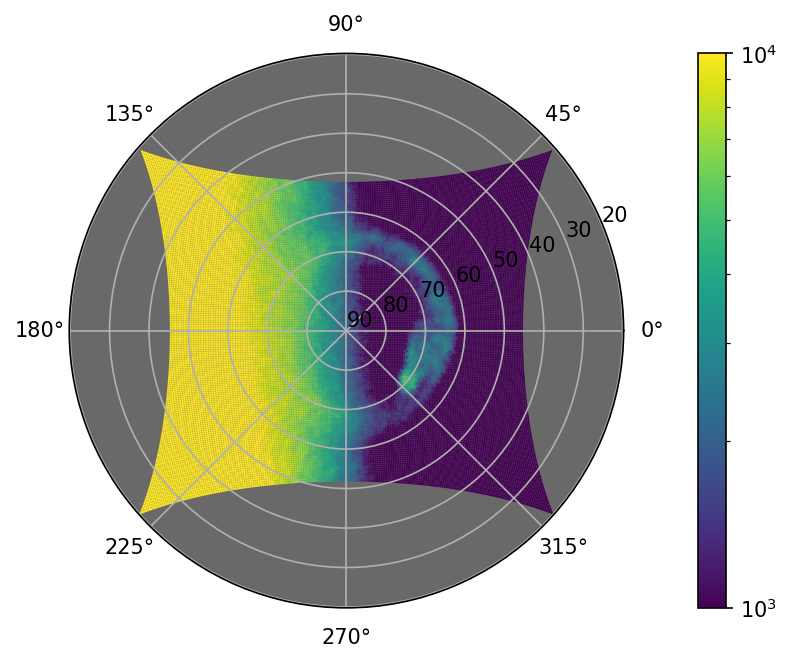

In [10]:
im = d['IM']
norm = cols.LogNorm(vmin=1000,vmax=10000)
dpl.guvi_plot(im[100,:,:].squeeze(),d['LAT_VERTS'],d['LON_VERTS'],norm=norm)

In [ ]:
# generate some images

InteractiveShell.ast_node_interactivity = "all"
norm = cols.LogNorm()
cmap = mpl.colormaps['inferno']

for i, im_p in zip(np.arange(im.shape[0]),im):
    dt = d['DateTime'][i] 
    plt.imshow(im_p[50:-20,y_arg], norm=norm,cmap=cmap)
    plt.title(f'{dt} -  {i:04}')
    plt.savefig(f'E:/Data/IMAGE/plots/{i:04}.png', bbox_inches='tight')




In [11]:
from scipy.optimize import curve_fit 
def gfit(x, A0, A1, A2, A3, A4):

    z = (x-A1)/A2

    return A0*np.exp(-0.5*(z**2)) + A3 + A4*x

def gfit_ns(x, A0, A1, A2, A3):

    z = (x-A1)/A2

    return A0*np.exp(-0.5*(z**2)) + A3

In [12]:
i_st = 152
i_en = 165

op = False

lat_c = list()
lon_c = list()
x_c = list()
y_c = list()
sig = list()
hgt = list()
cnt = list()
bas = list()

scn=0
jump=True
while scn < d['LAT_ARR'][0].shape[1]:
#for scn in np.arange(2):
    lats = d['LAT_ARR'][i_st][:,scn]
    lons = d['LON_ARR'][i_st][:,scn]

    scn_i = d['IM'][i_st][:,scn]
    scn_m = d['MLT_ARR'][i_st][:,scn]
    scn_x = (90-lats)*np.cos(np.deg2rad(lons))

    gd = np.where(scn_x > 0)

    g0 = scn_i[gd].max()-scn_i[gd].min()
    g1 = lats[gd[0][scn_i[gd].argmax()]]
    g2 = 5
    g3 = scn_i[gd].min()
    g4 = 0

    p, covariance = curve_fit(gfit_ns, lats[gd], scn_i[gd],p0=[g0,g1,g2,g3]) 
    
    p_bnd = p[1]+2*p[2]

    if p_bnd > lats[gd].max():
        if jump:
            jump=False
            # need to figure our which scan to jump to 
            # 
            mlt_nxt = d['MLT_ARR'][i_st][gd[0][10],scn:]
            scn = np.nanargmin(mlt_nxt)+scn 
            continue
        else:
            break

    if op:
        fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(5, 2))
        ax[0].plot(lats[gd],scn_i[gd])
        ax[0].plot(lats[gd],gfit_ns(lats[gd],p[0],p[1],p[2],p[3]))
        ax[1].imshow(d['IM'][i_st])
        ax[1].plot([scn,scn],[0,scn_x.shape[0]], color='red')
        plt.show()


    # find closest point from array
    pk_id = np.abs(lats[gd]-p[1]).argmin()

    lat_c.append(lats[gd[0][pk_id]])
    lon_c.append(lons[gd[0][pk_id]])

    x_c.append(scn)
    y_c.append(gd[0][pk_id])
    hgt.append(p[0])
    cnt.append(p[1])
    sig.append(p[2])
    bas.append(p[3])

    scn += 1




In [13]:
op=False
scn=0
jump=True


for scn, ht, ct, sg, bs in zip(x_c, hgt,cnt, sig, bas):
#for scn in np.arange(2):
    lats = d['LAT_ARR'][i_st][:,scn]
    lons = d['LON_ARR'][i_st][:,scn]

    scn_i = d['IM'][i_st][:,scn]
    scn_m = d['MLT_ARR'][i_st][:,scn]
    scn_x = (90-lats)*np.cos(np.deg2rad(lons))

    gd = np.where(scn_x < 0)

    g0 = ht
    g1 = ct
    g2 = sg
    g3 = bs
    g4 = 0

    gd = np.where((scn_x < 0) & (lats > (g1-5)) & (lats < (g1+20)))

    try:
        p, covariance = curve_fit(gfit, lats[gd], scn_i[gd],p0=[g0,g1,g2,g3,g4]) 
    except:
        continue

    if p[0] < 1000 or p[1]+3*p[2] > lats[gd].max() or p[1]-3*p[2] < lats[gd].min() or p[2] < 0:
        continue
    # find closest point from array
    pk_id = np.abs(lats[gd]-p[1]).argmin()

    lat_c.append(lats[gd[0][pk_id]])
    lon_c.append(lons[gd[0][pk_id]])
    sig.append(p[2])
    x_c.append(scn)
    y_c.append(gd[0][pk_id])

    if op:
        fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(5, 2))
        ax[0].plot(lats[gd],scn_i[gd])
        ax[0].plot(lats[gd],gfit(lats[gd],p[0],p[1],p[2],p[3], p[4]))
        ax[0].set_title(f'{scn}')
        ax[1].imshow(d['IM'][i_st])
        ax[1].plot([scn,scn],[0,scn_x.shape[0]], color='red')
        ax[1].scatter(scn,gd[0][pk_id])
        plt.show()


    

c:\Users\murph\miniconda3\envs\satdrag\lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


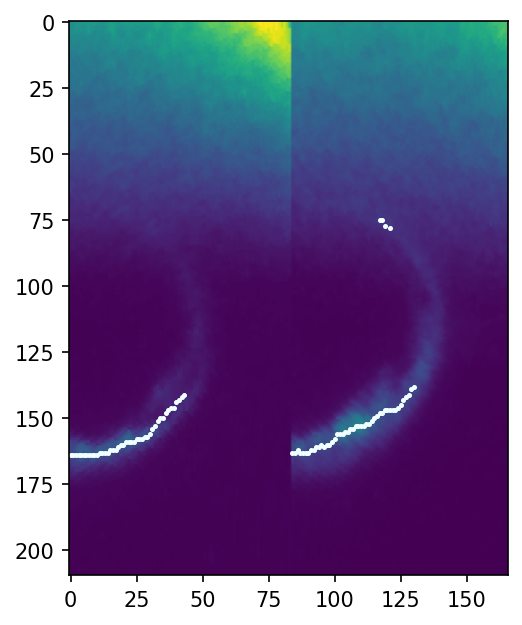

In [14]:
fig, ax = plt.subplots()

ax.imshow(d['IM'][i_st])
ax.scatter(x_c,y_c,2, color='azure')


In [15]:
def compute_a(points):
  n = len(points)
  value = np.ones((n, 3))
  for i in range(n):
    x, y = points[i]
    value[i, 0] = -2*x
    value[i, 1] = -2*y
  return value

def fit_circle(points):
  A = compute_a(Xf)
  Y = np.sum(np.square(Xf), axis=-1)
  Y = -Y
  a, b, k = (np.linalg.inv(A.T @ A) @ A.T) @ Y

  r = np.sqrt(a**2 + b**2 - k)

  return r, a, b


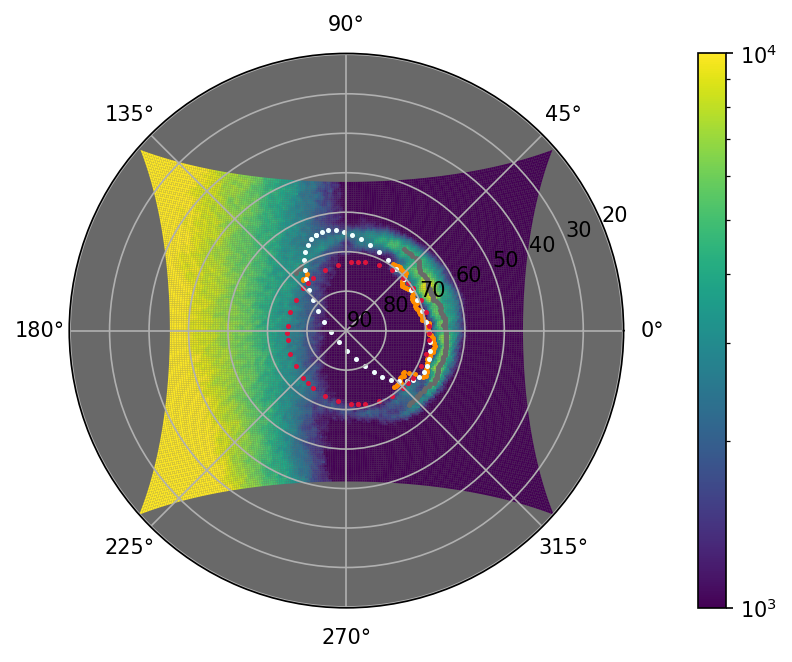

In [17]:
from ellipse import LsqEllipse

# convert to cartesian for fitting
# and add to single array
x = (90-(np.array(lat_c)+2*np.array(sig)))*np.cos(np.deg2rad(lon_c))
y = (90-(np.array(lat_c)+2*np.array(sig)))*np.sin(np.deg2rad(lon_c))

# construct array of points
Xf = np.array(list(zip(x, y)))

# fit a circle
c_fit = fit_circle(Xf)
circ = plt.Circle((c_fit[1], c_fit[2]), c_fit[0], color='r', fill=False).get_verts()
clon = np.arctan2(circ[:,1],circ[:,0])
clat = 90-np.sqrt(circ[:,0]**2+circ[:,1]**2)

# fit an ellipse
ell = LsqEllipse().fit(Xf)
e_c, sx, sy, e_a = ell.as_parameters()

e_a = e_a*-1
# derive ellipse use 2 degree spacing
vv = ell.return_fit(45)
vlat = 90-np.sqrt(vv[:,0]**2+vv[:,1]**2)
vlon = np.arctan2(vv[:,1],vv[:,0])

ax, p_col, c_bar = dpl.guvi_plot(d['IM'][i_st].squeeze(),d['LAT_VERTS'],d['LON_VERTS'],norm=norm)
ax.scatter(np.deg2rad(lon_c),lat_c,2, label='Center of Arc', color='dimgrey')
ax.scatter(np.deg2rad(lon_c),lat_c+2*np.array(sig),2, label='Poleward Edge', color='darkorange')
ax.scatter(vlon,vlat,2, label='Ellipse Fit', color='azure')
ax.scatter(clon, clat, 2, label='Circle Fit', color='crimson' )



# How does the fit change with fewer slices? 

In [20]:
# lets only look at scans in a specific region from dawn to dusk
# -30 < y < 30
lat_v = d['LAT_ARR'][i_st][104,:].copy()
lon_v = d['LON_ARR'][i_st][104,:].copy()

y_v = (90-(np.array(lat_v)))*np.sin(np.deg2rad(lon_v))
y_gd = np.where((y_v > -30) & (y_v < 30))

print(f'Number of scans between [-30,30] dawn to dusk: {y_gd[0].shape[0]}')
print(f'Total Scans: {y_v.shape[0]}')

Number of scans between [-30,30] dawn to dusk: 135
Total Scans: 166


Lets take every second, third, fourth, fifth and sixth scan and see how things change

In [25]:
len(lon_c)
len(lat_c)
len(sig)

95

95

95

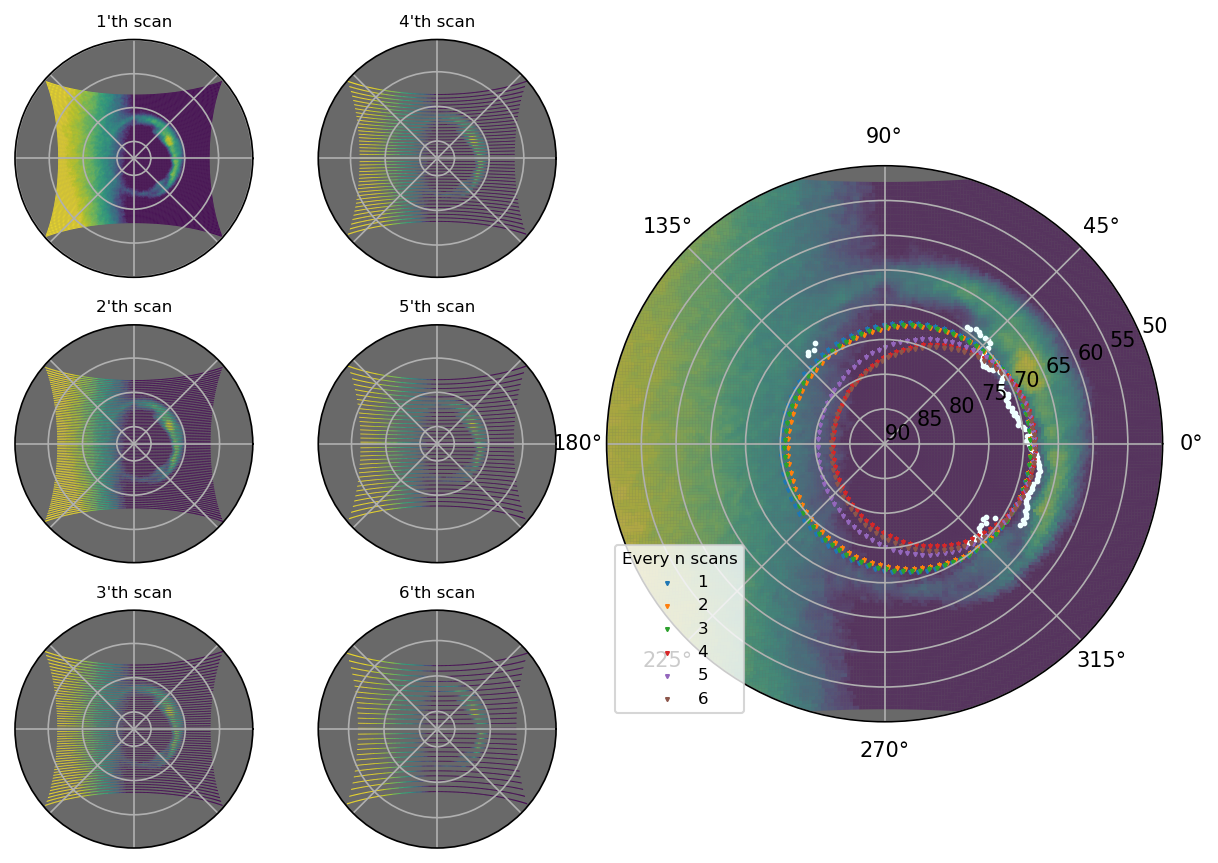

In [26]:
fig = plt.figure(figsize=[10,7])

gs = GridSpec(3,4)

ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[1,0])
ax3 = fig.add_subplot(gs[2,0])
ax4 = fig.add_subplot(gs[0,1])
ax5 = fig.add_subplot(gs[1,1])
ax6 = fig.add_subplot(gs[2,1])

ax7 = fig.add_subplot(gs[:,2:],projection='polar')

axes = fig.axes[:-1]

n = [1,2,3,4,5,6]

lat_c = np.array(lat_c)
lon_c = np.array(lon_c)
sig = np.array(sig)

xp = (90-(lat_c+2*sig))*np.cos(np.deg2rad(lon_c))
yp = (90-(lat_c+2*sig))*np.sin(np.deg2rad(lon_c))
scans = np.arange(0,d['IM'].shape[2])


ax7, _, cb = dpl.guvi_plot(d['IM'][i_st].squeeze(),d['LAT_VERTS'],d['LON_VERTS'],norm=norm,ax=ax7,alpha=0.5)
cb.remove()
_ = ax7.set_rlim(90,50)
_ = ax7.scatter(np.deg2rad(lon_c),lat_c+2*sig,3,color='azure')


for ns, axp in zip(n,axes):
    idx = [i for i, lv in enumerate(x_c) for scn_i in scans[::ns] if lv == scn_i]

    x = (90-(lat_c[idx]+2*sig[idx]))*np.cos(np.deg2rad(lon_c[idx]))
    y = (90-(lat_c[idx]+2*sig[idx]))*np.sin(np.deg2rad(lon_c[idx]))

    # construct array of points
    Xf = np.array(list(zip(x, y)))

    # fit a circle
    c_fit = fit_circle(Xf)

    rad = 2*np.pi*np.arange(0,90)/90.

    x_circ = c_fit[1]+c_fit[0]*np.cos(rad)
    y_circ = c_fit[2]+c_fit[0]*np.sin(rad)

    clon = np.arctan2(y_circ,x_circ)
    clat = 90-np.sqrt(y_circ**2+x_circ**2)

    r = np.hypot(x_circ, y_circ)
    th = np.degrees(np.arctan2(y_circ, x_circ))

    #ax1.scatter(x,y,4, )
    #ax1.scatter(x_circ, y_circ,4, marker='v',label=f'{ns}')
    _ = ax7.scatter(clon,clat,2, marker='v',label=f'{ns}')

    axp , _, cb = dpl.guvi_plot(d['IM'][i_st].squeeze()[:,::ns],d['LAT_VERTS'][:,::ns],d['LON_VERTS'][:,::ns],norm=norm,ax=axp)
    cb.remove()
    _ = axp.set_yticklabels([])
    _ = axp.set_xticklabels([])
    _ = axp.set_title(f"{ns}'th scan", fontsize=8)
    
#ax1.scatter(xp,yp,4,color='grey',label='Data')   

ax7.legend(loc=3,fontsize=8,title='Every n scans',title_fontsize=8)


In [37]:
op = False
n = [1,2,3,4,5,6]

mlt_bn = 0.25
mlt_val = np.array([np.arange(0,12,mlt_bn),np.arange(12,24,mlt_bn)[::-1]]).flatten() 

dat = dict()

for ns in n:

    mlt_bn = 0.25 if ns < 4 else 0.5
    mlt_val = np.array([np.arange(0,12,mlt_bn),np.arange(12,24,mlt_bn)[::-1]]).flatten() 

    im_par = d['IM'][i_st][::ns].flatten()
    lat_par = d['LAT_ARR'][i_st][::ns].flatten()
    lon_par = d['LON_ARR'][i_st][::ns].flatten()
    mlt_par = d['MLT_ARR'][i_st][::ns].flatten()

    lat_bn_c = list()
    sig_bn = list()
    lon_bn_c = list()
    mlt_bn_c = list()

    jump=False


    for mlt_st in mlt_val:
        if op:
            print(f'Starting: {mlt_st:05.2f} - {mlt_st+mlt_bn:05.2f}')
        gd = np.where((mlt_par>=mlt_st) & (mlt_par<(mlt_st+mlt_bn)))

        lat_f = lat_par[gd]
        lon_f = lon_par[gd]
        im_f = im_par[gd]

        gd_l = np.where(lat_f > 50)

        if mlt_st == 0 or jump:
            g0 = im_f[gd_l].max()-im_f[gd_l].min()
            g1 = lat_f[im_f[gd_l].argmax()]
            g2 = 5
            g3 = im_f[gd_l].min()
            g4 = 0
        else:
            g0 = p[0]
            g1 = p[1]
            g2 = p[2]
            g3 = p[3]
            g4 = p[4]

           

        try:
            p, covariance = curve_fit(gfit, lat_f[gd_l], im_f[gd_l],p0=[g0,g1,g2,g3,g4])
            jump = False
        except:
            if op:
                print(f'Skipping: {mlt_st:05.2f} - {mlt_st+mlt_bn:05.2f}')
            jump = True
            continue

        if p[0] < 500 or p[1]+3*p[2] > lat_f[gd_l].max() or p[1]-3*p[2] < lat_f[gd_l].min() or p[2] < 0:
            if op:
                print(f'Skipping bad fit: {p[0]}, {p[1]+3*p[2]}, {p[1]-3*p[2]}')
            jump=True
            continue

        if op:
            fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(5, 2))
            _ = ax.scatter(lat_f, im_f,2)
            _ = ax.scatter(lat_f,gfit(lat_f,p[0],p[1],p[2],p[3],p[4]),2)
            _ = ax.set_title(f'{mlt_st:05.2f} - {mlt_st+mlt_bn:05.2f}')
            #plt.show()

        lat_bn_c.append(p[1])
        sig_bn.append(p[2])
        lon_bn_c.append(lon_f[gd_l].mean())
        mlt_bn_c.append(mlt_st+mlt_bn/2.)

    fit_dic = {'lats':np.array(lat_bn_c), 'sigma':np.array(sig_bn), 'lons':np.array(lon_bn_c), 'mlts':np.array(mlt_bn_c)}
    dat[ns] = fit_dic


c:\Users\murph\miniconda3\envs\satdrag\lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [29]:
dat.keys()
dat[1].keys()

dict_keys([1, 2, 3, 4, 5, 6])

dict_keys(['lats', 'sigma', 'lons', 'mlts'])

In [47]:
lat_f = dat[ks]['lats']+2*dat[ks]['sigma']

lat_f.mean()-3*lat_f.std()

65.25564821591188

(69,) , (69,)
(72,) , (72,)
(67,) , (67,)
(32,) , (33,)
(32,) , (32,)
(33,) , (33,)


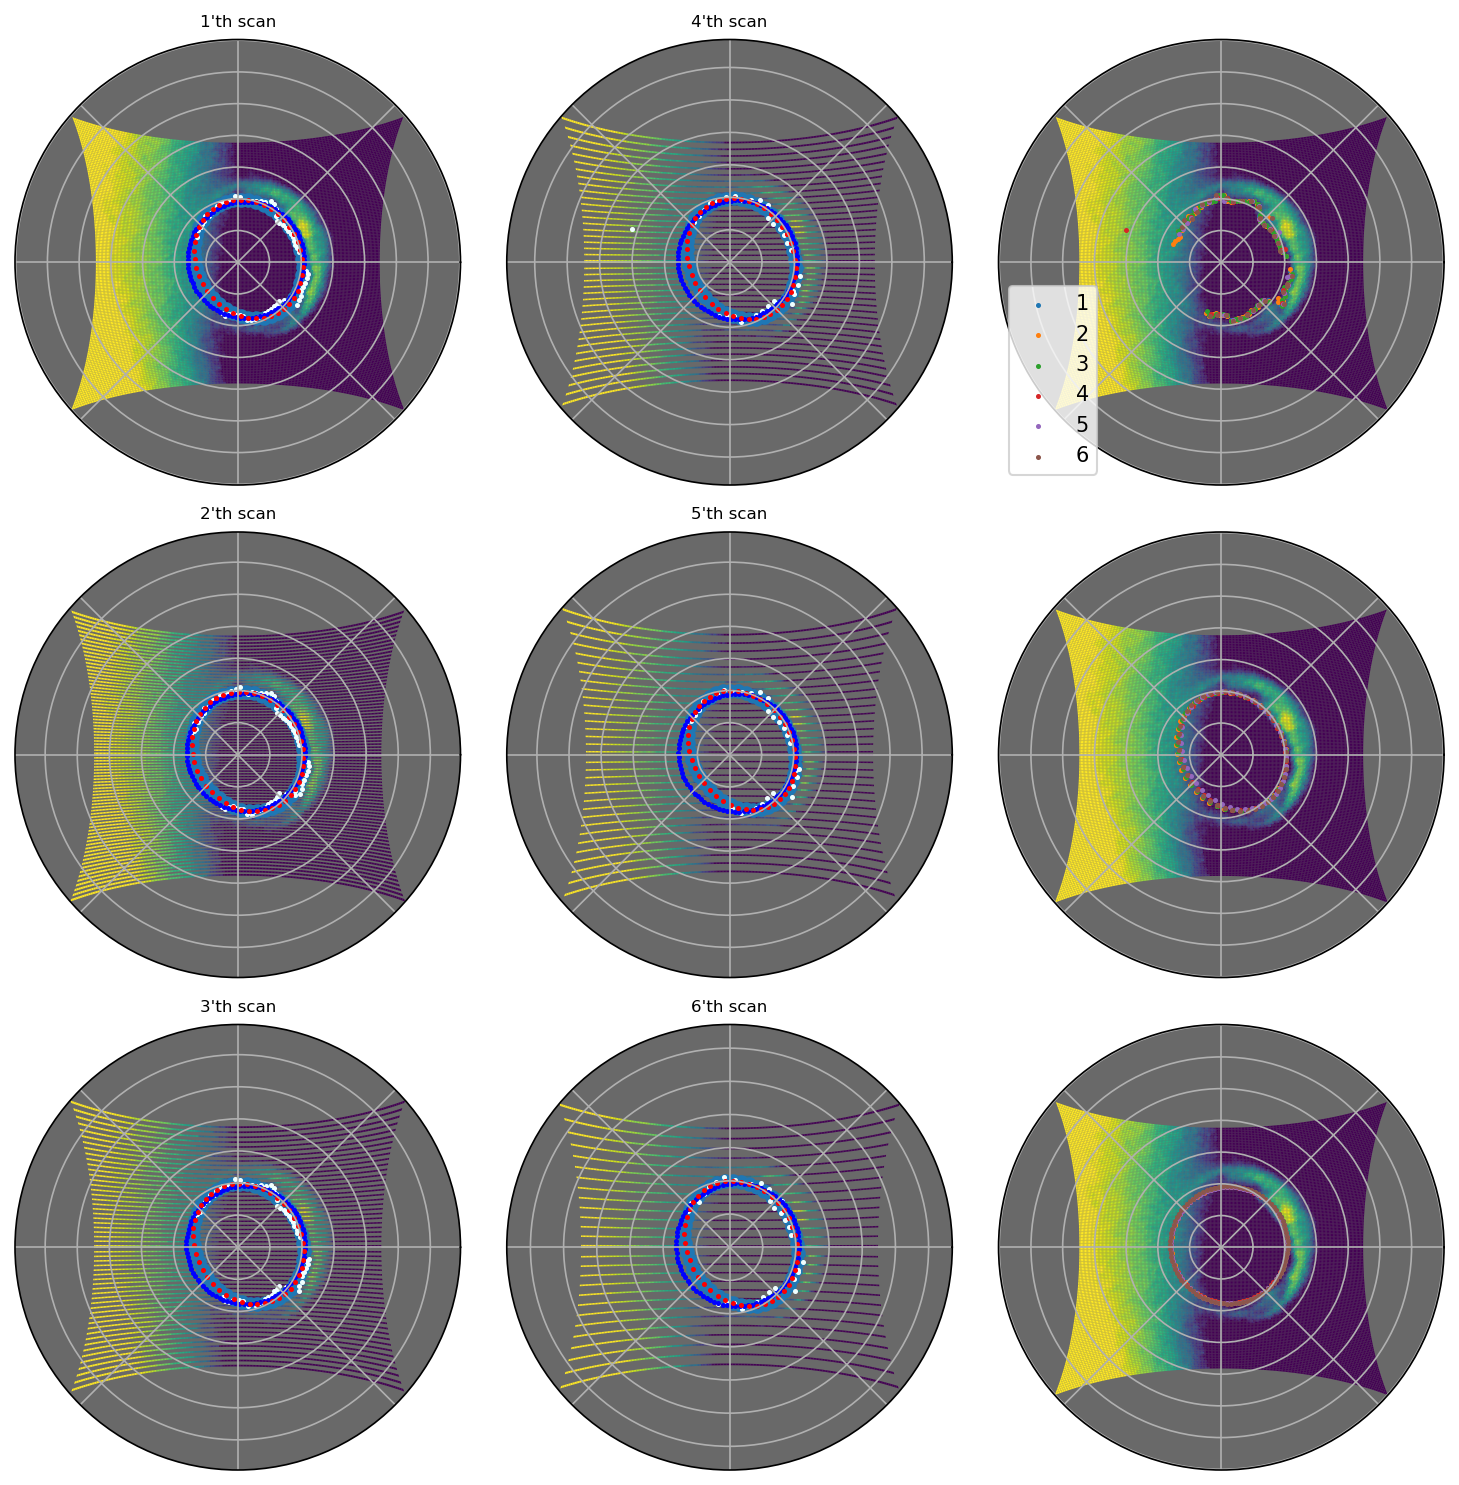

In [59]:
fig = plt.figure(figsize=[10,10])

gs = GridSpec(3,3)

ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[1,0])
ax3 = fig.add_subplot(gs[2,0])
ax4 = fig.add_subplot(gs[0,1])
ax5 = fig.add_subplot(gs[1,1])
ax6 = fig.add_subplot(gs[2,1])
ax7 = fig.add_subplot(gs[0,2],projection='polar')
ax8 = fig.add_subplot(gs[1,2],projection='polar')
ax9 = fig.add_subplot(gs[2,2],projection='polar')

axes = fig.get_axes()[:-1]

ax7 , _, cb = dpl.guvi_plot(d['IM'][i_st].squeeze()[:,::1],d['LAT_VERTS'][:,::1],d['LON_VERTS'][:,::1],norm=norm, ax=ax7)
cb.remove()
_ = ax7.set_yticklabels([])
_ = ax7.set_xticklabels([])
ax8 , _, cb = dpl.guvi_plot(d['IM'][i_st].squeeze()[:,::1],d['LAT_VERTS'][:,::1],d['LON_VERTS'][:,::1],norm=norm, ax=ax8)
cb.remove()
_ = ax8.set_yticklabels([])
_ = ax8.set_xticklabels([])
ax9 , _, cb = dpl.guvi_plot(d['IM'][i_st].squeeze()[:,::1],d['LAT_VERTS'][:,::1],d['LON_VERTS'][:,::1],norm=norm, ax=ax9)
cb.remove()
_ = ax9.set_yticklabels([])
_ = ax9.set_xticklabels([])
#axp.scatter(np.deg2rad(lon_bn_c),lat_bn_c,2, color='white')

for ks, axp in zip(dat.keys(),axes):

    lat_f = dat[ks]['lats']+2*dat[ks]['sigma']
    lon_f = np.deg2rad(dat[ks]['lons'])

    gd = np.where(lat_f > (lat_f.mean()-3*lat_f.std()))

    print(f'{gd[0].shape} , {lat_f.shape}')
    
    x = (90-lat_f[gd[0]])*np.cos(lon_f[gd[0]])
    y = (90-lat_f[gd[0]])*np.sin(lon_f[gd[0]])

    # construct array of points
    Xf = np.array(list(zip(x, y)))

    # fit a circle
    c_fit = fit_circle(Xf)

    rad = 2*np.pi*np.arange(0,90)/90.

    x_circ = c_fit[1]+c_fit[0]*np.cos(rad)
    y_circ = c_fit[2]+c_fit[0]*np.sin(rad)

    clon = np.arctan2(y_circ,x_circ)
    clat = 90-np.sqrt(y_circ**2+x_circ**2)

    # fit an ellipse
    e_fit = LsqEllipse().fit(Xf)

    # derive ellipse use 2 degree spacing
    vv = e_fit.return_fit(45)
    elat = 90-np.sqrt(vv[:,0]**2+vv[:,1]**2)
    elon = np.arctan2(vv[:,1],vv[:,0])

    axp, _, cb = dpl.guvi_plot(d['IM'][i_st].squeeze()[:,::ks],d['LAT_VERTS'][:,::ks],d['LON_VERTS'][:,::ks],norm=norm, ax=axp)
    cb.remove()
    _ = axp.scatter(elon,elat,label=f'{n}')
    _ = axp.set_yticklabels([])
    _ = axp.set_xticklabels([])
    _ = axp.set_title(f"{ks}'th scan", fontsize=8)

    _ = axp.scatter(lon_f,lat_f,2, color='azure')
    _ = axp.scatter(clon, clat,2, color='blue')
    _ = axp.scatter(elon, elat,2, color='red')

    _ = ax7.scatter(lon_f,lat_f,2, label=f'{ks}')
    _ = ax8.scatter(elon,elat,2)
    _ = ax9.scatter(clon,clat,2)

    dat[ks]['cir_lat'] = clat
    dat[ks]['cir_lon'] = np.rad2deg(clon)

    dat[ks]['ell_lat'] = elat
    dat[ks]['ell_lon'] = np.rad2deg(elon)

ax7.legend(loc=3)
plt.tight_layout()                                                     

C:\Users\murph\AppData\Local\Temp\ipykernel_35344\3698630916.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[2].legend()


C:\Users\murph\AppData\Local\Temp\ipykernel_35344\3698630916.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[3].legend()


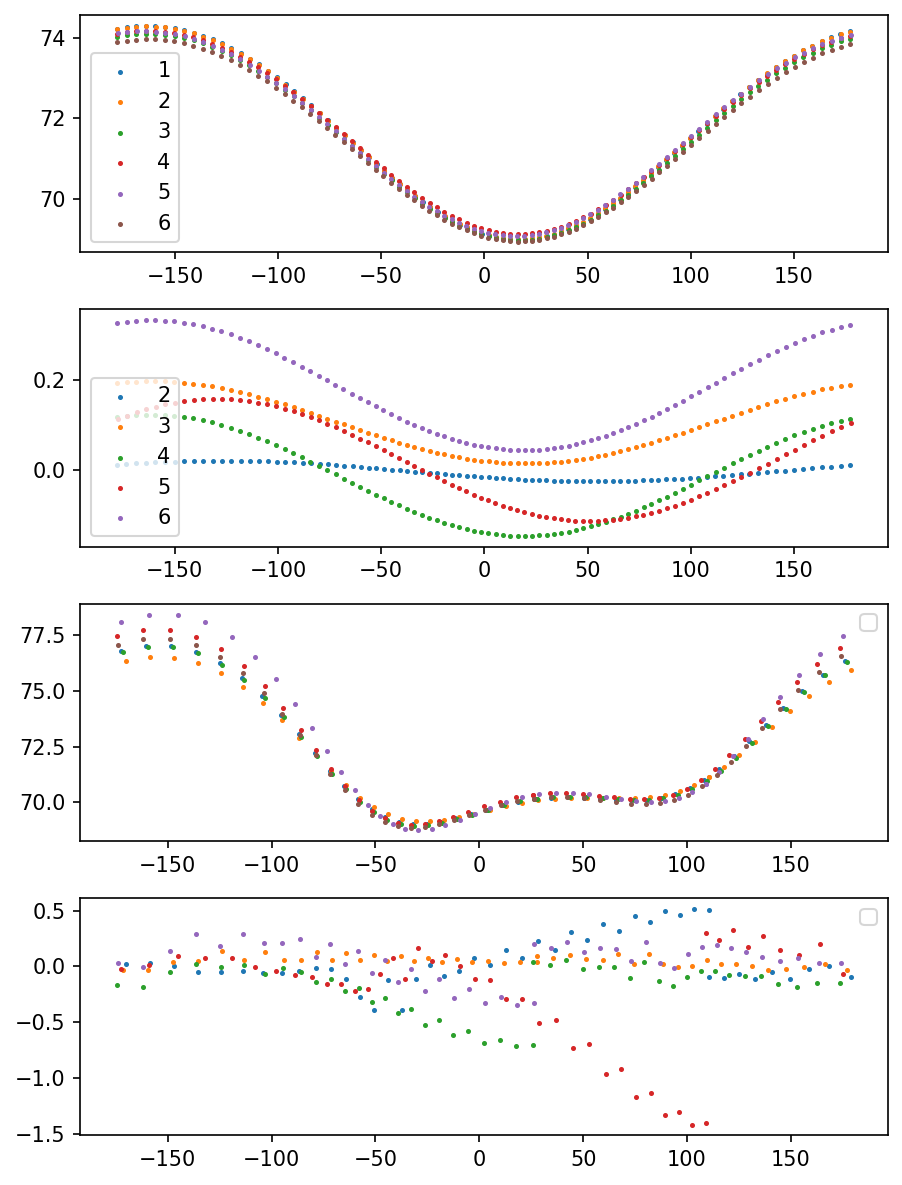

In [ ]:
fig, ax = plt.subplots(4,1,figsize=[6,8])

for ks in dat.keys():
    _ = ax[0].scatter(dat[ks]['cir_lon'],dat[ks]['cir_lat'],2,label=f'{ks}')
    _ = ax[2].scatter(dat[ks]['ell_lon'],dat[ks]['ell_lat'],2,label=f'{ks}')

    if ks !=1:
        _ = ax[1].scatter(dat[ks]['cir_lon'],dat[1]['cir_lat']-dat[ks]['cir_lat'],2,label=f'{ks}')
        _ = ax[3].scatter(dat[ks]['ell_lon'],np.sort(dat[1]['ell_lat'])-np.sort(dat[ks]['ell_lat']),2,label=f'{ks}')

ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[3].legend()
plt.tight_layout() 

In [ ]:
lon_c[1:]-lon_c[:-1]

In [ ]:
ax1.set_t

In [ ]:
sig[idx]

In [ ]:
ax, p_col, c_bar = dpl.guvi_plot(d['IM'][i_st].squeeze(),d['LAT_VERTS'],d['LON_VERTS'],norm=norm)

In [ ]:
a = np.where(scn_x > 0)

In [ ]:
plt.plot(scn_m,im_s)

In [ ]:
from skimage import feature

In [ ]:
d['LAT_ARR'][i_st].shape

In [ ]:
lat_v = d['LAT_ARR'][i_st][104,:].copy()
lon_v = d['LON_ARR'][i_st][104,:].copy()

y_v = (90-(np.array(lat_v)))*np.sin(np.deg2rad(lon_v))
y_c = np.argsort(y_v)
plt.plot(y_v)

In [ ]:
import matplotlib.pyplot as plt
from skimage import data, img_as_float
from skimage.segmentation import chan_vese


lat_v = d['LAT_ARR'][i_st][104,:].copy()
lon_v = d['LON_ARR'][i_st][104,:].copy()

y_v = (90-(np.array(lat_v)))*np.sin(np.deg2rad(lon_v))
y_c = np.argsort(y_v)

image = d['IM'][i_st][:,y_c]
# Feel free to play around with the parameters to see how they impact the result
cv = chan_vese(
    image,
    mu=0.25,
    lambda1=1,
    lambda2=1,
    tol=1e-3,
    max_num_iter=200,
    dt=0.5,
    init_level_set="checkerboard",
    extended_output=True,
)

fig, axes = plt.subplots(2, 2, figsize=(8, 8))
ax = axes.flatten()

ax[0].imshow(image, cmap="gray")
ax[0].set_axis_off()
ax[0].set_title("Original Image", fontsize=12)

ax[1].imshow(cv[0], cmap="gray")
ax[1].set_axis_off()
title = f'Chan-Vese segmentation - {len(cv[2])} iterations'
ax[1].set_title(title, fontsize=12)

ax[2].imshow(cv[1], cmap="gray")
ax[2].set_axis_off()
ax[2].set_title("Final Level Set", fontsize=12)

ax[3].plot(cv[2])
ax[3].set_title("Evolution of energy over iterations", fontsize=12)

fig.tight_layout()
plt.show()

In [ ]:
plt.plot(cv[1][:,50])
plt.plot(cv[1][:,125])

In [ ]:
plt.imshow(cv[1], vmin=0)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import skimage as ski


def store_evolution_in(lst):
    """Returns a callback function to store the evolution of the level sets in
    the given list.
    """

    def _store(x):
        lst.append(np.copy(x))

    return _store


# Morphological ACWE
image = cv[1]

# Initial level set
init_ls = ski.segmentation.checkerboard_level_set(image.shape, 6)
# List with intermediate results for plotting the evolution
evolution = []
callback = store_evolution_in(evolution)
ls = ski.segmentation.morphological_chan_vese(
    image, num_iter=35, init_level_set=init_ls, smoothing=3, iter_callback=callback
)

fig, axes = plt.subplots(2, 2, figsize=(8, 8))
ax = axes.flatten()

ax[0].imshow(image, cmap="gray")
ax[0].set_axis_off()
ax[0].contour(ls, [0.5], colors='r')
ax[0].set_title("Morphological ACWE segmentation", fontsize=12)

ax[1].imshow(ls, cmap="gray")
ax[1].set_axis_off()
ax[1].set_title("Morphological ACWE evolution", fontsize=12)

contour_labels = []
for n, color in ((2, 'g'), (7, 'y'), (35, 'r')):
    ax[1].contour(evolution[n], [0.5], colors=color)

    # Use empty line to represent this contour in the legend
    legend_line = mlines.Line2D([], [], color=color, label=f"Iteration {n}")
    contour_labels.append(legend_line)

ax[1].legend(handles=contour_labels, loc="upper right")

# Morphological GAC
image = cv[1]
gimage = ski.segmentation.inverse_gaussian_gradient(image)

# Initial level set
init_ls = np.zeros(image.shape, dtype=np.int8)
init_ls[10:-10, 10:-10] = 1
# List with intermediate results for plotting the evolution
evolution = []
callback = store_evolution_in(evolution)
ls = ski.segmentation.morphological_geodesic_active_contour(
    gimage,
    num_iter=230,
    init_level_set=init_ls,
    smoothing=1,
    balloon=-1,
    threshold=0.69,
    iter_callback=callback,
)

ax[2].imshow(image, cmap="gray")
ax[2].set_axis_off()
ax[2].contour(ls, [0.5], colors='r')
ax[2].set_title("Morphological GAC segmentation", fontsize=12)

ax[3].imshow(ls, cmap="gray")
ax[3].set_axis_off()
ax[3].set_title("Morphological GAC evolution", fontsize=12)

contour_labels = []
for n, color in ((0, 'g'), (100, 'y'), (230, 'r')):
    ax[3].contour(evolution[n], [0.5], colors=color)

    # Use empty line to represent this contour in the legend
    legend_line = mlines.Line2D([], [], color=color, label=f"Iteration {n}")
    contour_labels.append(legend_line)

ax[3].legend(handles=contour_labels, loc="upper right")

fig.tight_layout()
plt.show()

In [ ]:
plt.imshow(im[5,:,0:84])

In [ ]:
%%timeit

for slc_f, slc_d in zip(imf.transpose(), im0.transpose()):
    id_nan = idx[~slc_f]
    id_fin = idx[slc_f]
    for id in id_nan:
        id_close = np.abs(id_fin-id).argmin() 
        slc_d[id] = slc_d[id_fin[id_close]]
    

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(d['IM'][-40],vmin=1000,vmax=10000)

In [ ]:
import matplotlib.colors as cols
norm = cols.LogNorm()
cmap=plt.cm.inferno

In [ ]:
guvi_plot(im0,d['LAT_VERTS'],d['LON_VERTS'])

In [ ]:
guvi_plot(d['IM'][0],d['LAT_VERTS'],d['LON_VERTS'])

In [ ]:
d.keys()
d['LAT_ARR'].shape

In [ ]:
plt.plot(im0[105:-1,100])
plt.plot(im0[0:105,100])